In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from add_planck_galccs.generate_galcc_maps import build_galactic_clump_map, add_PGCC2PySM
from add_planck_galccs.galcc_utils import plot_compare
import pysm3
import pysm3.units as u
import pandas as pd
import mapsims
from pathlib import Path
from time import time
from astropy.io import fits
import numpy as np

# Generating Maps of Cold Galactic Clumps from the Planck Galactic Cold Clump (PGCC) Catalogue
### We also will be reading in Planck GNILC maps and adding these Galactic Cold Clump maps to test the position/scale/orientation of the sources and see if they are present in the GNILC Maps.

### Comparisons are made between using GNILC Release 2 maps, GNILC PySM3 templates and COMMANDER dust maps

### Polarisation fraction is examined around PGCC source locations


### Finally we also have an example of scaling the frequency from the measured 353 GHz data in the PGCC catalogue to a new frequency to be used by SO (in this example 27 GHz) 

In [73]:
# Read Planck Cold Galactic Clump Catalogue
df = pd.read_csv('PGCC.csv')
glons = df['glon']
glats = df['glat']


# Read GNILC maps: Frequencies {857, 545, 353 GHz}
GNILC_freq_folder = "/global/homes/j/justinc/Galactic Cold Clumps/Data/"
GNILC_freqdir = Path(GNILC_freq_folder)
gnilc_map_353 = hp.read_map(GNILC_freqdir / "COM_CompMap_Dust-GNILC-F353_2048_R2.00.fits")
gnilc_map_545 = hp.read_map(GNILC_freqdir / "COM_CompMap_Dust-GNILC-F545_2048_R2.00.fits")
gnilc_map_857 = hp.read_map(GNILC_freqdir / "COM_CompMap_Dust-GNILC-F857_2048_R2.00.fits")
IQU_Commander_R3 = hp.read_map(GNILC_freqdir / "HFI_CompMap_Foregrounds-commander-353_R3.00.fits", field = (0,1,2))
CompMap_ThermalDust_Commander = hp.read_map(GNILC_freqdir / "COM_CompMap_ThermalDust-commander_2048_R2.00.fits", field = (0, 7))
# Read GNILC maps: Temperature and Beta
GNILC_spectral_folder = "/global/project/projectdirs/cmb/www/pysm-data/dust_gnilc/"  # NERSC
GNILC_specdir = Path(GNILC_spectral_folder)
gnilc_dust_Td_nside2048 = hp.read_map(GNILC_specdir / "gnilc_dust_Td_nside2048.fits")
gnilc_dust_Bd_nside2048 = hp.read_map(GNILC_specdir / "gnilc_dust_beta_nside2048.fits")
thermaldustIQU_GNILC_varres = hp.read_map(GNILC_specdir / "inputs/COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits", field = (0,1,2))

#### Generate Galactic Cold Clump maps at specified frequencies

In [74]:
# Create empty HEALPix map with given Nside
# Read source catalogue to get source properties and build empty map at given Nside
base_map = build_galactic_clump_map(nside = 2048, catalogue = "PGCC.csv")

# Generate Galactic Cold Clump maps at Planck measured frequencies
galccmap_353 = base_map.cold_clumps_flux(freq_out = 353, output_units = u.MJy/u.sr)
galccmap_545 = base_map.cold_clumps_flux(freq_out = 545, output_units = u.MJy/u.sr)
galccmap_857 = base_map.cold_clumps_flux(freq_out = 857, output_units = u.MJy/u.sr)

# Generate Galactic Cold Clump maps of Temperature and Spectral Emissivity
galccmap_temp, _ = base_map.cold_clumps_spectral(maptype = 'temp')
galccmap_beta, _ = base_map.cold_clumps_spectral(maptype = 'beta')

In [75]:
# Add Galactic Cold Clump Maps to Planck GNILC frequency, temperature and beta maps
combined_gnilcmap_353 = gnilc_map_353.copy()
combined_gnilcmap_545 = gnilc_map_545.copy()
combined_gnilcmap_857 = gnilc_map_857.copy()
combined_gnilcmap_353 += galccmap_353
combined_gnilcmap_545 += galccmap_545
combined_gnilcmap_857 += galccmap_857

combined_gnilcmap_temp = gnilc_dust_Td_nside2048.copy()
combined_gnilcmap_beta = gnilc_dust_Bd_nside2048.copy()
combined_gnilcmap_temp += galccmap_temp
combined_gnilcmap_beta += galccmap_beta

# Planck GNILC Maps (left) with added Planck Galactic Cold Clumps (right)
## Note the essentially 1-1 correlation between sources in the GNILC maps with the sources from PGCC catalogue generated maps
Difference in brightness is just due to adding the sources ontop of themselves to observe location, size, shape, rotation angle etc.

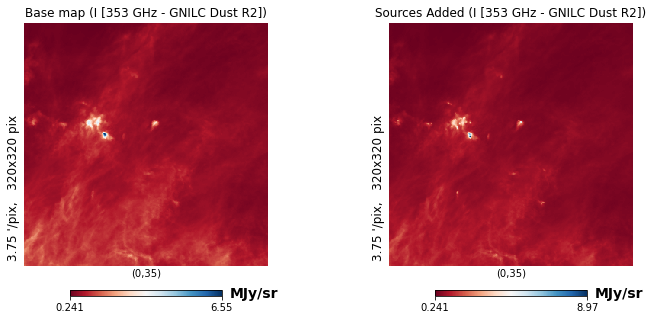

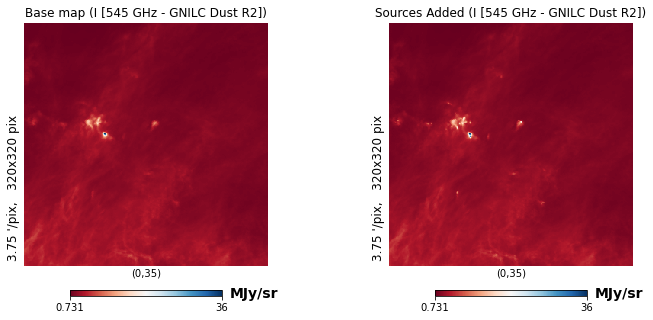

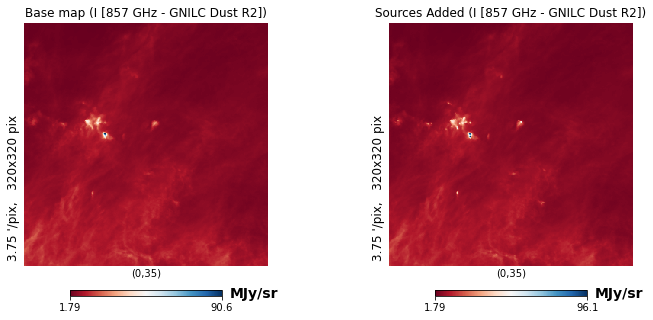

In [76]:
rot = [0, 35]
reso = 3.75
xsize = ysize = 320

plot_compare(gnilc_map_353, combined_gnilcmap_353, 
             maptype = "I [353 GHz - GNILC Dust R2]", rot = rot, 
             reso = reso, xsize = xsize, 
             ysize = ysize, unit = "MJy/sr")

plot_compare(gnilc_map_545, combined_gnilcmap_545, 
             maptype = "I [545 GHz - GNILC Dust R2]", rot = rot, 
             reso = reso, xsize = xsize, 
             ysize = ysize, unit = "MJy/sr")

plot_compare(gnilc_map_857, combined_gnilcmap_857, 
             maptype = "I [857 GHz - GNILC Dust R2]", rot = rot, 
             reso = reso, xsize = xsize, 
             ysize = ysize, unit = "MJy/sr")

# Temperature and Beta Planck GNILC Maps with added PGCC sources

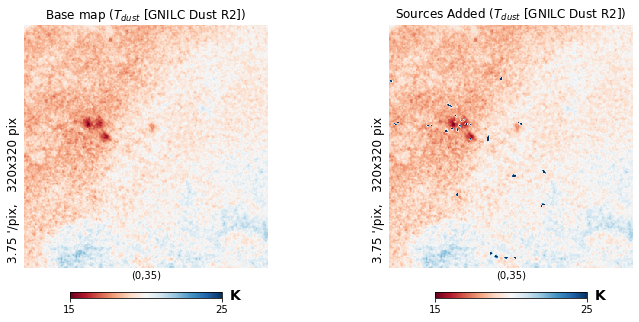

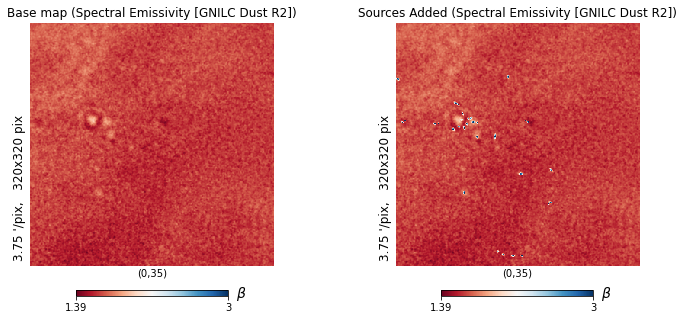

In [77]:
plot_compare(gnilc_dust_Td_nside2048, combined_gnilcmap_temp, 
             maptype = "$T_{dust}$ [GNILC Dust R2]", rot = rot, 
             reso = reso, xsize = xsize, min = 15, max = 25, 
             ysize = ysize, unit = "K")

plot_compare(gnilc_dust_Bd_nside2048, combined_gnilcmap_beta, 
             maptype = "Spectral Emissivity [GNILC Dust R2]", rot = rot, 
             reso = reso, xsize = xsize, min = 1.39, max = 3,
             ysize = ysize, unit = "$\\beta$")

# Comparing COMMANDER and PySM3 dust sky models

### Commander release 2 545 GHz intensity map and spectral emissitivty

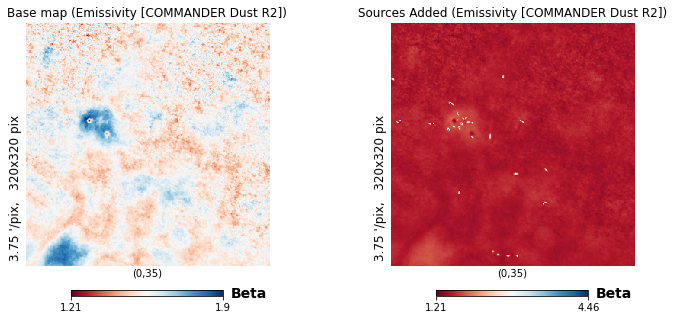

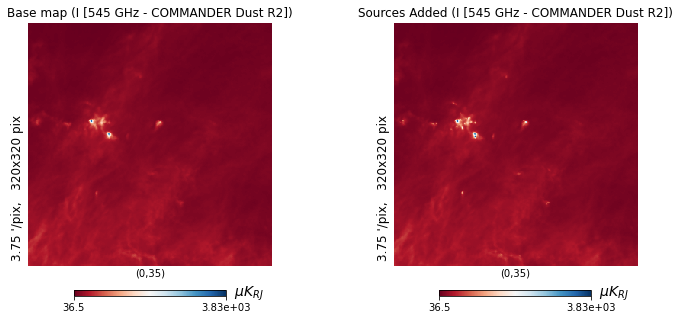

In [78]:
galccmap_545_uKRJ = (galccmap_545*u.MJy/u.sr).to_value(u.uK_RJ, equivalencies = u.cmb_equivalencies(545 * u.GHz))
commander_R2_545_combined = CompMap_ThermalDust_Commander[0].copy()
commander_R2_545_combined += galccmap_545_uKRJ

commander_R2_beta_combined = CompMap_ThermalDust_Commander[1].copy()
commander_R2_beta_combined += galccmap_beta

plot_compare(CompMap_ThermalDust_Commander[1], commander_R2_beta_combined, 
             maptype = "Emissivity [COMMANDER Dust R2]",
             rot = rot, reso = reso, xsize = xsize, 
             ysize = ysize, unit = "Beta")
plot_compare(CompMap_ThermalDust_Commander[0], commander_R2_545_combined, 
             maptype = "I [545 GHz - COMMANDER Dust R2]",
             rot = rot, reso = reso, xsize = xsize, 
             ysize = ysize, unit = "$\\mu K_{RJ}$")

### PySM3 d9 & d10 dust sky models

Td is a constant =  19.6 K
bd is a constant =  1.48


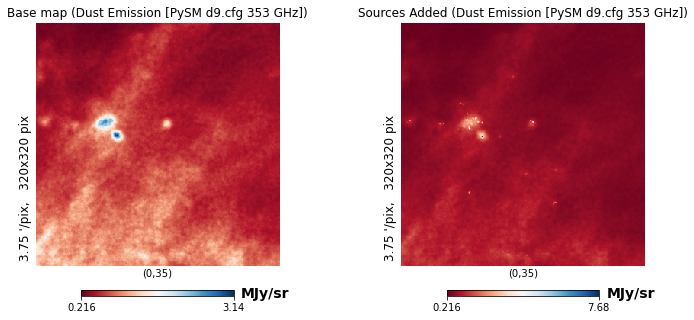

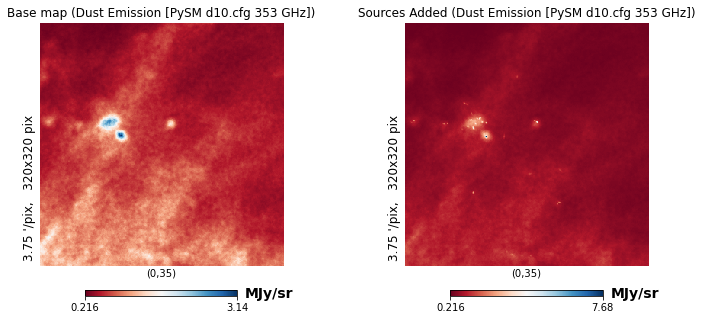

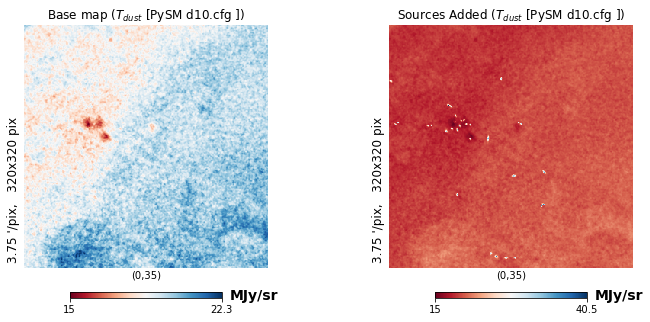

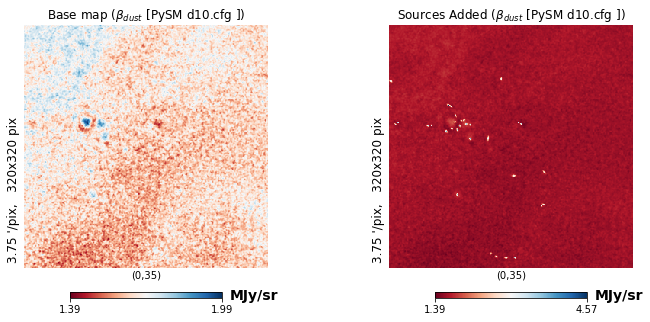

In [79]:
add_PGCC2PySM(2048, 353, u.MJy/u.sr, 'd9.cfg', 'PGCC.csv',
              rot = [0, 35], reso = 3.75, xsize = 320, ysize = 320, unit = "MJy/sr")

add_PGCC2PySM(2048, 353, u.MJy/u.sr, 'd10.cfg', '/global/homes/j/justinc/SO_Galactic_Cold_Clumps/PGCC.csv',
              rot = [0, 35], reso = 3.75, xsize = 320, ysize = 320, unit = "MJy/sr")

# Observing Polarisation Fraction

In [80]:
# GNILC varres
GNILC_V_I = thermaldustIQU_GNILC_varres[0] # Intensity
GNILC_V_Q = thermaldustIQU_GNILC_varres[1] # Q-Pol
GNILC_V_U = thermaldustIQU_GNILC_varres[2] # U-Pol
GNILC_V_P = np.sqrt(GNILC_V_Q**2 + GNILC_V_U**2) # Pol
GNILC_V_PolFrac = GNILC_V_P / GNILC_V_I # Polarisation Fraction
# Commander release 3
commander_I = IQU_Commander_R3[0] # Intensity
commander_Q = IQU_Commander_R3[1] # Q-Pol
commander_U = IQU_Commander_R3[2] # U-Pol
commander_P = np.sqrt(commander_Q**2 + commander_U**2) # Pol
commander_PolFrac = commander_P / commander_I # Polarisation Fraction

In [84]:
# PySM3 d10
sky_d10 = pysm3.Sky(nside = 2048, component_config = 'd10.cfg')
d10_emission = sky_d10.get_emission(353 * u.GHz)
d10_emission = d10_emission.to(u.K_CMB, equivalencies = u.cmb_equivalencies(353 * u.GHz))
d10_I = d10_emission[0]
d10_Q = d10_emission[1]
d10_U = d10_emission[2]
d10_P = np.sqrt(d10_Q**2 + d10_U**2)
d10_PolFrac = d10_P / d10_I

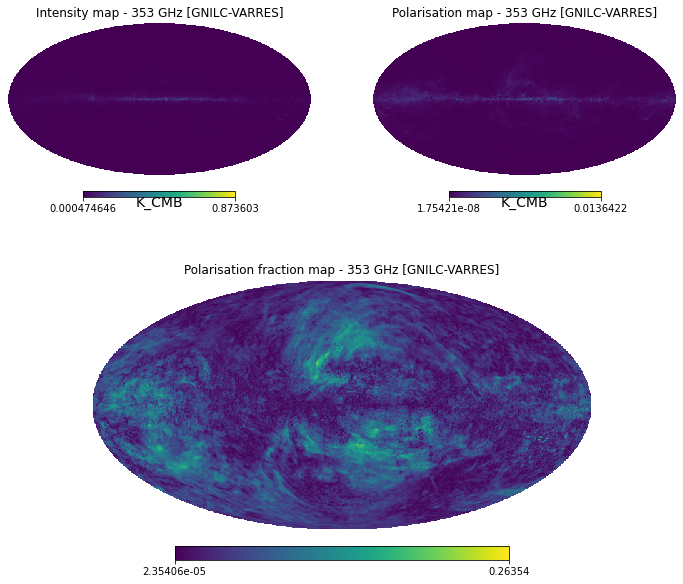

In [85]:
gs = gridspec.GridSpec(2,2)
plt.figure(figsize = (12, 12,))
ax = plt.subplot(gs[0, 0])
hp.mollview(GNILC_V_I, 
            title = "Intensity map - 353 GHz [GNILC-VARRES]", 
            unit = u.K_CMB, 
            hold = True)
ax = plt.subplot(gs[0, 1])
hp.mollview(GNILC_V_P, 
            title = "Polarisation map - 353 GHz [GNILC-VARRES]", 
            unit = u.K_CMB, 
            hold = True)
ax = plt.subplot(gs[1, :])
hp.mollview(GNILC_V_PolFrac, 
            title = "Polarisation fraction map - 353 GHz [GNILC-VARRES]", 
            hold = True)

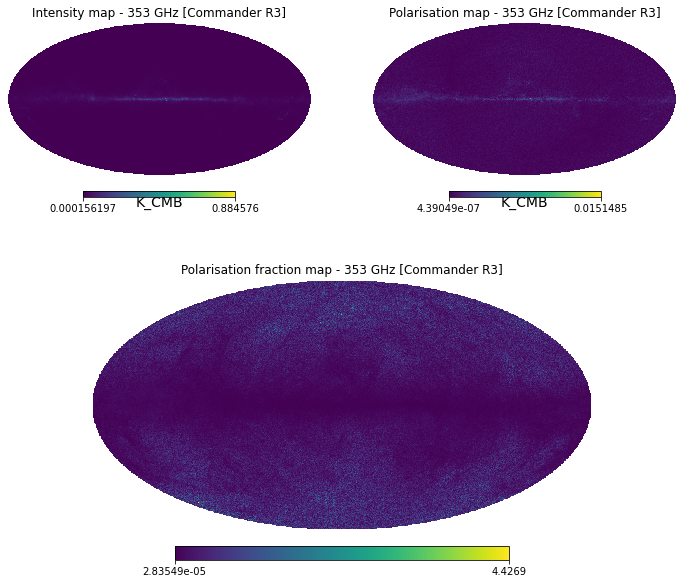

In [86]:
gs = gridspec.GridSpec(2,2)
plt.figure(figsize = (12, 12,))
ax = plt.subplot(gs[0, 0])
hp.mollview(commander_I, 
            title = "Intensity map - 353 GHz [Commander R3]", 
            unit = u.K_CMB, 
            hold = True)
ax = plt.subplot(gs[0, 1])
hp.mollview(commander_P, 
            title = "Polarisation map - 353 GHz [Commander R3]", 
            unit = u.K_CMB, 
            hold = True)
ax = plt.subplot(gs[1, :])
hp.mollview(commander_PolFrac, 
            title = "Polarisation fraction map - 353 GHz [Commander R3]", 
            hold = True)

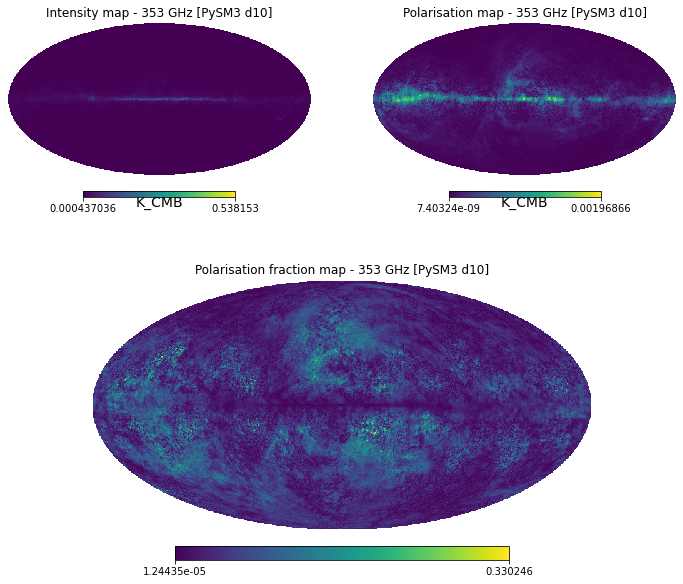

In [87]:
gs = gridspec.GridSpec(2,2)
plt.figure(figsize = (12, 12,))
ax = plt.subplot(gs[0, 0])
hp.mollview(d10_I, 
            title = "Intensity map - 353 GHz [PySM3 d10]", 
            unit = u.K_CMB, 
            hold = True)
ax = plt.subplot(gs[0, 1])
hp.mollview(d10_P, 
            title = "Polarisation map - 353 GHz [PySM3 d10]", 
            unit = u.K_CMB, 
            hold = True)
ax = plt.subplot(gs[1, :])
hp.mollview(d10_PolFrac, 
            title = "Polarisation fraction map - 353 GHz [PySM3 d10]", 
            hold = True)

Polarisation fraction will be measured out to $2\times\theta_{maj}$ of each source.

In [95]:
radii = df['gau_major_axis']
source_regions = []
for i in range(len(df)):
    vec = hp.ang2vec(glons[i], glats[i], lonlat = True)
    radius = (radii[i] * u.arcmin).to_value(u.rad)
    pix_circ = hp.query_disc(nside = 2048, vec = vec, radius = 2 * radius)
    source_regions.append(pix_circ)
    
mean_source_PF_GNILC_V = []
mean_source_PF_commander = []
mean_source_PF_d10 = []
for i in range(len(df)):
    if source_regions[i].any():
        mean_source_PF_GNILC_V.append(np.mean(GNILC_V_PolFrac[source_regions[i]]))
        mean_source_PF_commander.append(np.mean(commander_PolFrac[source_regions[i]]))
        mean_source_PF_d10.append(np.mean(d10_PolFrac[source_regions[i]]))
        
max_source_PF_GNILC_V = []
max_source_PF_commander = []
max_source_PF_d10 = []
for i in range(len(df)):
    if source_regions[i].any():
        max_source_PF_GNILC_V.append(np.max(GNILC_V_PolFrac[source_regions[i]]))
        max_source_PF_commander.append(np.max(commander_PolFrac[source_regions[i]]))
        max_source_PF_d10.append(np.max(d10_PolFrac[source_regions[i]]))

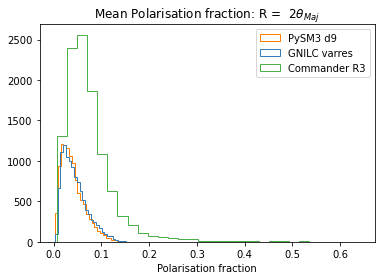

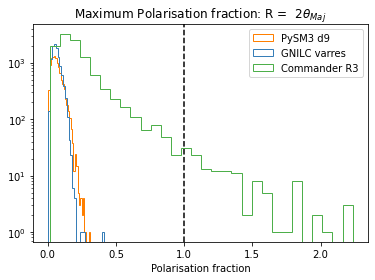

In [108]:
plt.title('Mean Polarisation fraction: R =  2$\\theta_{Maj}$')
plt.hist(np.array(mean_source_PF_d10), bins = 30, 
         histtype = 'step',
         label = 'PySM3 d9', color = '#ff7f00')
plt.hist(np.array(mean_source_PF_GNILC_V), bins = 30, 
         histtype = 'step',
         label = 'GNILC varres', color = '#377eb8')
plt.hist(np.array(mean_source_PF_commander), bins = 30, 
         histtype = 'step',
         label = 'Commander R3', color = '#4daf4a')
plt.xlabel('Polarisation fraction')
plt.legend()
plt.show();

plt.title('Maximum Polarisation fraction: R =  2$\\theta_{Maj}$')
plt.hist(np.array(max_source_PF_d10), bins = 30, 
         histtype = 'step',
         label = 'PySM3 d9', color = '#ff7f00')
plt.hist(np.array(max_source_PF_GNILC_V), bins = 30, 
         histtype = 'step',
         label = 'GNILC varres', color = '#377eb8')
plt.hist(np.array(max_source_PF_commander), bins = 30, 
         histtype = 'step',
         label = 'Commander R3', color = '#4daf4a')
plt.xlabel('Polarisation fraction')
plt.axvline(1, color = 'black', ls = '--')
plt.legend()
plt.yscale('log')
plt.show();

# Scaling Frequency Example: 
## From 353 GHz to 27 GHz

In [26]:
base_map = build_galactic_clump_map(nside = 2048, catalogue = "PGCC.csv")
units = u.MJy/u.sr

galccmap_27 = base_map.cold_clumps_flux(freq_out = 27, store_maps = False, output_units = units)

galccmap_39 = base_map.cold_clumps_flux(freq_out = 39, store_maps = False, output_units = units)

galccmap_93 = base_map.cold_clumps_flux(freq_out = 93, store_maps = False, output_units = units)

galccmap_145 = base_map.cold_clumps_flux(freq_out = 145, store_maps = False, output_units = units)

galccmap_225 = base_map.cold_clumps_flux(freq_out = 225, store_maps = False, output_units = units)

galccmap_280 = base_map.cold_clumps_flux(freq_out = 280, store_maps = False, output_units = units)

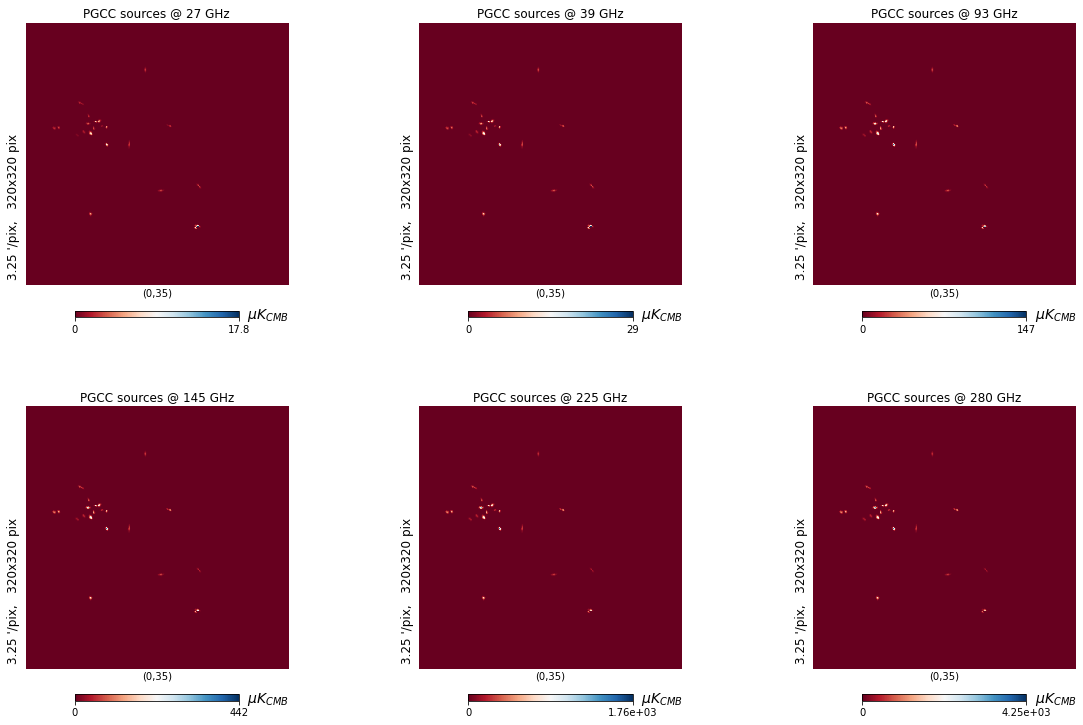

In [21]:
rot = [0, 35]
reso = 3.25
xsize = ysize = 320
gs = gridspec.GridSpec(3, 3)
plt.figure(figsize = (20, 20))
unit_label = "$\\mu K_{CMB}$"
#unit_label = "MJy / sr"

ax = plt.subplot(gs[0, 0])
hp.gnomview(galccmap_27, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'PGCC sources @ 27 GHz', unit = unit_label, cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[0, 1])
hp.gnomview(galccmap_39, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'PGCC sources @ 39 GHz', unit = unit_label, cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[0, 2])
hp.gnomview(galccmap_93, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'PGCC sources @ 93 GHz', unit = unit_label, cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[1, 0])
hp.gnomview(galccmap_145, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'PGCC sources @ 145 GHz', unit = unit_label, cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[1, 1])
hp.gnomview(galccmap_225, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'PGCC sources @ 225 GHz', unit = unit_label, cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[1, 2])
hp.gnomview(galccmap_280, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'PGCC sources @ 280 GHz', unit = unit_label, cmap = 'RdBu', hold = True)

# Mask Sources

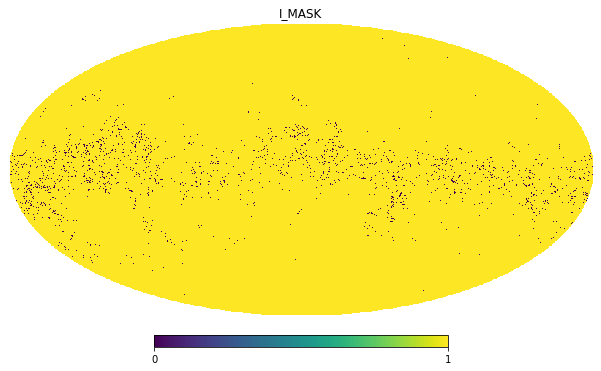

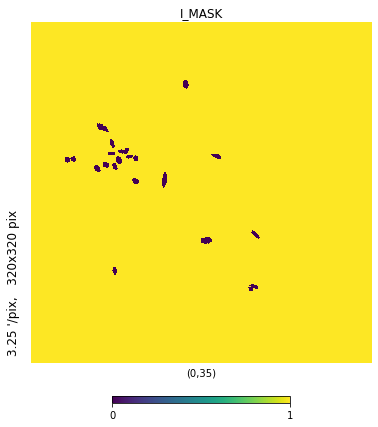

In [10]:
base_map = build_galactic_clump_map(nside = 2048, catalogue = "PGCC.csv")

source_mask = base_map.mask_sources()
hp.mollview(source_mask, title = 'I_MASK')
hp.gnomview(source_mask, rot = rot, reso = reso, xsize = xsize, ysize = ysize, 
            title = 'I_MASK')